In [2]:
import json
import sklearn
import requests
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from __future__ import division
import tensorflow as tf
import numpy as np
import tarfile
import os
import json
import matplotlib.pyplot as plt
import time

In [3]:
with open("./zenodo_open_metadata_06_04_2017.json", "r") as fp:
    data = json.load(fp)
spams = [17229, 400865, 19031, 285825, 440002, 292995, 221828, 18818, 160518, 32519, 437895, 22211, 290571, 438157, 44942, 33550, 246800, 51728, 398866, 400531, 60051, 50704, 32918, 164886, 164888, 495001, 165784, 34331, 321818, 60828, 346531, 399268, 18045, 27942, 35364, 30632, 202291, 47155, 293045, 47286, 290359, 224947, 29113, 375738, 20539, 17596, 293053, 439998, 439997, 290237, 49089, 440001, 440003, 440004, 440005, 440006, 440007, 154696, 440009, 440008, 290123, 35276, 284358, 398797, 32076, 33365, 249942, 290134, 344537, 166752, 291812, 18281, 46445, 51054, 290685, 34287, 28271, 439999, 232944, 290157, 23155, 290166, 440000, 249981]
maybe_spams = [153959, 12846, 13138, 13385, 398764, 400012]
for d in data:
    if d['recid'] in (spams + maybe_spams):
        d['spam'] = True
labels = [d['spam'] for d in data]

In [4]:
def feat_tr(d):
    return d['description'] + d['title']

X = [feat_tr(d) for d in data]
y = np.array([[1 if d['spam'] else 0, 1 if not d['spam'] else 0] for d in data])

ngram_range=(1, 1)
count_vect = CountVectorizer(ngram_range=ngram_range)
X_v = count_vect.fit_transform(X)

trainX, testX, trainY, testY = train_test_split(X_v, y, test_size=0.33, random_state=42)

In [5]:
numFeatures = trainX.shape[1]
numLabels = trainY.shape[1]
numEpochs = 27000
# a smarter learning rate for gradientOptimizer
learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [6]:
# X = X-matrix / feature-matrix / data-matrix... It's a tensor to hold our email
# data. 'None' here means that we can hold any number of emails
X = tf.placeholder(tf.float32, [None, numFeatures])
# yGold = Y-matrix / label-matrix / labels... This will be our correct answers
# matrix. Every row has either [1,0] for SPAM or [0,1] for HAM. 'None' here 
# means that we can hold any number of emails
yGold = tf.placeholder(tf.float32, [None, numLabels])

In [7]:
# Values are randomly sampled from a Gaussian with a standard deviation of:
#     sqrt(6 / (numInputNodes + numOutputNodes + 1))

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numLabels+1)),
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias"))

In [8]:
# INITIALIZE our weights and biases
init_OP = tf.initialize_all_variables()

# PREDICTION ALGORITHM i.e. FEEDFORWARD ALGORITHM
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [9]:
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

In [10]:
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

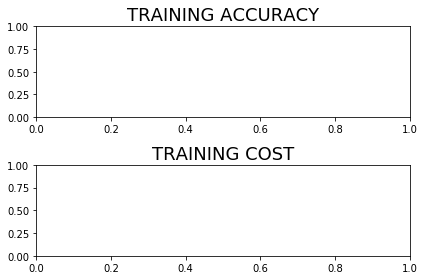

In [11]:
epoch_values=[]
accuracy_values=[]
cost_values=[]
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
plt.tight_layout()

In [12]:
trainX[0]

<1x429893 sparse matrix of type '<class 'numpy.int64'>'
	with 24 stored elements in Compressed Sparse Row format>

In [13]:
#####################
### RUN THE GRAPH ###
#####################

# Create a tensorflow session
sess = tf.Session()

# Initialize all tensorflow variables
sess.run(init_OP)

## Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)
# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)
# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)
# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))
# Merge all summaries
all_summary_OPS = tf.summary.merge_all()
# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            summary_results, train_accuracy, newCost = sess.run(
                [all_summary_OPS, accuracy_OP, cost_OP], 
                feed_dict={X: trainX, yGold: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g"%(i, train_accuracy))
            print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost %g"%(i, diff))

            # Plot progress to our two subplots
            accuracyLine, = ax1.plot(epoch_values, accuracy_values)
            costLine, = ax2.plot(epoch_values, cost_values)
            fig.canvas.draw()
            time.sleep(1)


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))

ValueError: setting an array element with a sequence.

In [50]:
# Create Saver
saver = tf.train.Saver()
# Save variables to .ckpt file
# saver.save(sess, "trained_variables.ckpt")

# Close tensorflow session
sess.close()